In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage[per-mode=symbol]{siunitx}'
rcParams['text.usetex']         = True
rcParams['font.family']         = 'sans-serif'
rcParams['font.sans-serif']     = ['Helvetica']

In [2]:
import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

### Things to add on if there is time
* error propagation (through derivatives, etc.)
* units (pint module)

### Universal Constants

In [3]:
frame_rate = Q_(1.0/30.0,'s') # seconds
mass_red   = None # grams
mass_base  = None # grams

mass_blue = None # grams
L = 2.0 # meters

# Ball Drop Analysis

### Data Initialization

In [4]:
### Initialize drop data
drop_data = {}
drop_data['red']  = {}
drop_data['base'] = {}

for _ in list(drop_data.keys()):
    drop_data[_]['pos'] = []
    
### Red Ball
    
drop_data['red']['pos'].append(Q_(np.array([
-5.936958196E-3,-1.783706639E-2,-3.355164627E-2,-6.482071833E-2,
-1.065598482E-1,-1.625838494E-1,-2.265381929E-1,-2.995025198E-1,
-3.880640950E-1,-4.820012928E-1,-5.901702800E-1,-7.101803071E-1,
-8.417722297E-1,-9.812655362E-1,-1.131187792E0,-1.288931383E0,
-1.463604859E0,-1.656525098E0,-1.859888688E0
]),'m'))

drop_data['red']['pos'].append(Q_(np.array([
-1.845200028E-2,-2.248757992E-2,-3.664592119E-2,-6.276491897E-2,
-1.005815509E-1,-1.488511144E-1,-2.087006494E-1,-2.791366361E-1,
-3.623878433E-1,-4.550103558E-1,-5.605537921E-1,-6.777754358E-1,
-8.055530902E-1,-9.436950147E-1,-1.090978896E0,-1.251257602E0,
-1.416770659E0,-1.605736760E0,-1.797309309E0,-2.003203811E0
]),'m'))

drop_data['red']['pos'].append(Q_(np.array([
8.694084861E-3,8.945858629E-4,-1.334832349E-2,-3.932128996E-2,
-7.818590364E-2,-1.251658226E-1,-1.846611109E-1,-2.612697346E-1,
-3.430954271E-1,-4.365466250E-1,-5.416541965E-1,-6.585605907E-1,
-7.870232695E-1,-9.233695741E-1,-1.073921059E0,-1.227107364E0,
-1.399788745E0,-1.575056790E0,-1.767145753E0,-1.948891417E0
]),'m'))

### Baseball

drop_data['base']['pos'].append(Q_(np.array([
-2.664755198E-2,-4.367235057E-2,-6.462707975E-2,
-1.011454247E-1,-1.310553813E-1,-1.935970963E-1,-2.602199722E-1,
-3.369954352E-1,-4.256249872E-1,-5.300028910E-1,-6.460000231E-1,
-7.516147643E-1,-8.819911787E-1,-1.024100135E0,-1.185734071E0,
-1.348705090E0,-1.524702426E0,-1.674635952E0,-1.876740599E0,-2.056624767E0
]),'m'))

drop_data['base']['pos'].append(Q_(np.array([
1.494029606E-2,-4.660327995E-3,-3.371800097E-2,-5.976583962E-2,
-1.093965489E-1,-1.635243614E-1,-2.423808379E-1,-3.229186144E-1,
-4.108708311E-1,-5.141070872E-1,-6.252422019E-1,-7.519278209E-1,
-8.904166982E-1,-1.035491405E0,-1.228814281E0,-1.389542590E0,
-1.534582460E0,-1.707065799E0,-1.931825282E0
]),'m'))

drop_data['base']['pos'].append(Q_(np.array([
-2.211146866E-2,-3.094413983E-2,-4.291057729E-2,-6.380538559E-2,
-9.356474780E-2,-1.403537802E-1,-1.989516002E-1,-2.653531140E-1,
-3.458360358E-1,-4.434010458E-1,-5.385375726E-1,-6.516118574E-1,
-7.817008924E-1,-9.156849628E-1,-1.063953627E0,-1.229717403E0,
-1.381908163E0,-1.560052643E0,-1.768917493E0,-1.993943144E0
]),'m'))

### Add errors
$\delta y = {\rm diameter} + 1 {\rm cm} + \sqrt{20\times{\rm frame}}$

In [5]:
def get_error(frame,which):
    if which=='red': diam=Q_(7,'cm')
    elif which=='base': diam=Q_(7.5,'cm')
    alfa = (diam/2.0)**2.0 / 20.0
    return diam / 2.0 + Q_(1.0,'cm') + np.sqrt(alfa * frame)

In [6]:
for key in drop_data.keys():
    drop_data[key]['err'] = []
    for i in range(len(drop_data[key]['pos'])):
        errors = get_error(np.arange(0,len(drop_data[key]['pos'][i])),key)
        drop_data[key]['err'].append(errors)

In [7]:
# y  = drop_data['red']['pos'][0].magnitude
# dy = drop_data['red']['err'][0].to('m').magnitude

# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))
# ax.errorbar(np.arange(0,len(y)),y,yerr=dy,dash_capstyle='butt',capsize=3,fmt='k.')
# plt.show()

### Calculate derivatives

In [8]:
# def derivative(f):
#     g    = f.magnitude
#     rate = frame_rate.magnitude
#     N = len(f)
#     deriv = np.zeros(N)
#     deriv[0]  = (g[1] - g[0])/rate
#     deriv[-1] = (g[-1] - g[-2])/rate
    
#     for i in range(2,N-2):
#         deriv[i] = (g[i+1] - g[i-1])/2.0/rate
#     return Q_(deriv,f.units/frame_rate.units)

# def second_derivative(f):
#     return derivative(derivative(f))

def second_derivative(f):#,f_err):
    g    = f.magnitude
    # h    = f_err.magnitude
    rate = frame_rate.magnitude
    N = len(f)
    deriv = np.zeros(N)
    # error = np.zeros(N)
    deriv[0]  = (g[0] - 2*g[1] + g[2])/rate**2.0
    deriv[1]  = (g[0] - 2*g[1] + g[2])/rate**2.0
    deriv[-2] = (g[-1] - 2*g[-2] + g[-3])/rate**2.0
    deriv[-1] = (g[-1] - 2*g[-2] + g[-3])/rate**2.0

    ### Errors blow up -- likely an issue with covariance or something neglected
    # error[0]  = np.sqrt(h[0]**2.0 + (2*h[1])**2.0 + h[2]**2.0)/rate**2.0
    # error[1]  = np.sqrt(h[0]**2.0 + (2*h[1])**2.0 + h[2]**2.0)/rate**2.0
    # error[-2] = np.sqrt(h[-1]**2.0 + (2*h[-2])**2.0 + h[-3]**2.0)/rate**2.0
    # error[-1] = np.sqrt(h[-1]**2.0 + (2*h[-2])**2.0 + h[-3]**2.0)/rate**2.0
    
    for i in range(2,N-2):
        deriv[i] = (-g[i+2] + 16*g[i+1] - 30*g[i] + 16*g[i-1] - g[i-2])/12.0/rate**2.0
        # error[i] = np.sqrt(h[i+2]**2.0 + (16*h[i+1])**2.0 + (30*h[i])**2.0 + (16*h[i-1]**2.0) + (g[i-2])**2.0)/12.0/rate**2.0
    return Q_(deriv,f.units/frame_rate.units**2)#,Q_(error,f_err.units/frame_rate.units**2)

def get_a_w_error(f,f_err):
    # g  = f.magntiude
    # dg = f_err.to(f.units).magntiude
    upper = f + f_err.to(f.units)
    lower = f - f_err.to(f.units)
    
    a_mean  = second_derivative(f)
    a_upper = second_derivative(upper)
    a_lower = second_derivative(lower)
    a_error = 0.5*abs(a_upper-a_lower) 
    #np.maximum(abs(a_upper-a_mean),abs(a_lower-a_mean))
    #np.array([max(abs(a_upper[i] - a_mean[i]),abs(a_lower[i]-a_mean[i])) for i in range(len(a_mean))])
    
    return a_mean,a_error

In [9]:
a = second_derivative(drop_data['red']['pos'][0])#,drop_data['red']['err'][0])
a = get_a_w_error(drop_data['red']['pos'][0],drop_data['red']['err'][0])

In [10]:
### error blows up for first two points
### likely to do with large relative error in position
# a[1]

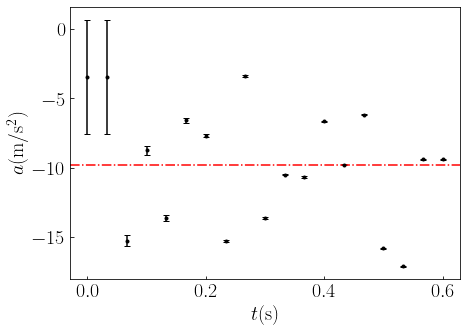

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5))

ax.errorbar(frame_rate.magnitude*np.arange(0,len(a[0])),a[0].magnitude,yerr=a[1].to('m/s**2').magnitude,fmt='k.',dash_capstyle='butt',capsize=3)
ax.axhline(y=-9.8,color='r',linestyle='-.')
ax.set_xlabel(r'$t ({:Lx})$'.format(frame_rate.units),size=20)
ax.set_ylabel(r'$a ({:Lx})$'.format(a[0].units),size=20)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)

plt.show()

### Fit g

In [12]:
def fit_g(a,da):
    g  = np.mean(a)
    dg = np.sqrt(np.sum(da**2.0))/float(len(a))
    return g,dg

In [13]:
g_fits = {}
for key in drop_data.keys():
    g_fits[key] = []
    
for key in drop_data.keys():
    # print(key)
    for i in range(len(drop_data[key]['pos'])):
        pos_data = drop_data[key]['pos'][i]
        err_data = drop_data[key]['err'][i]
        a_data,a_err = get_a_w_error(pos_data,err_data)
        # print(pos_data)
        # print(a_data)
        # print(a_err)
        # print()
        g_mean,g_err = fit_g(a_data,a_err)
        g_mean = g_mean.to('m/s**2').magnitude
        g_err  = g_err.to('m/s**2').magnitude
        g_fits[key].append(np.array([g_mean,g_err]))
    g_fits[key] = Q_(np.array(g_fits[key]),'m/s**2')

In [14]:
g_fits['red']

Magnitude,[[-9.821838498939481 0.30894046382098983] [-10.1466226266 0.293495278566711] [-7.773773175160109 0.2934952785667114]]
Units,meter/second2


In [15]:
g_fits['base']

Magnitude,[[-6.828191764425021 0.3144592270357613] [-12.495019990006579 0.33100763980820236] [-10.673267771212469 0.3144592270357611]]
Units,meter/second2


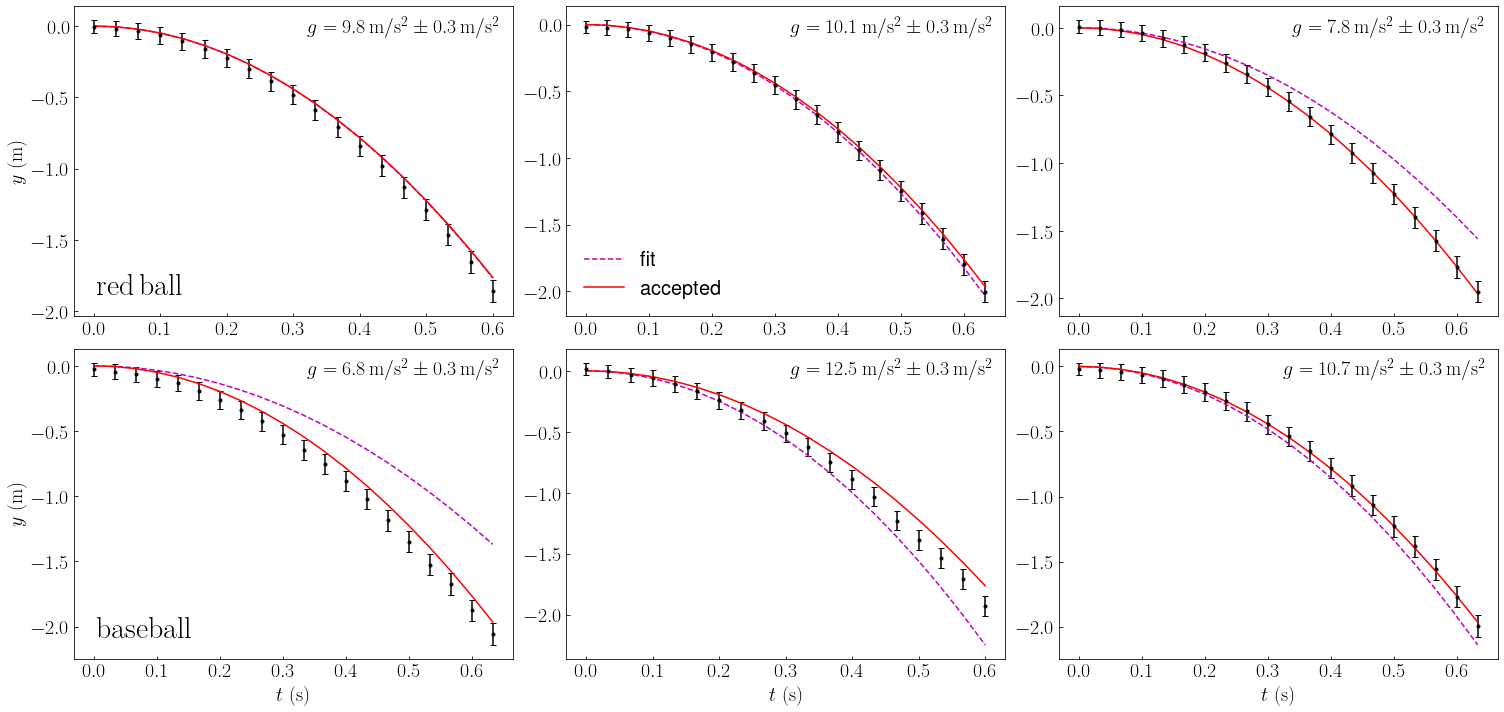

In [23]:
f = lambda g_,t: g_*t**2.0/2.0

nrows=2;ncols=3
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for key in drop_data.keys():
    if key == 'red':
        i = 0
        ax[0][0].text(0.05,0.05,r'$\rm red\,ball$',size=30,transform=ax[0][0].transAxes,va='bottom',ha='left')    
    if key == 'base':
        i = 1
        ax[1][0].text(0.05,0.05,r'$\rm baseball$',size=30,transform=ax[1][0].transAxes,va='bottom',ha='left')        
        # ax[1][2].set_xlabel(r'$t~({:Lx})$'.format(frame_rate.units),size=20)
    g_vals = g_fits[key]
    for j in range(len(drop_data[key]['pos'])):
        pos = drop_data[key]['pos'][j]
        err = drop_data[key]['err'][j].to(pos.units).magnitude
        pos = pos.magnitude
        ax[i][j].errorbar(frame_rate.magnitude*np.arange(0,len(pos)),pos,yerr=err,fmt='k.',capsize=3)
        t_vals = Q_(frame_rate.magnitude*np.arange(0,len(pos)),frame_rate.units)
        ax[i][j].plot(frame_rate.magnitude*np.arange(0,len(pos)),f(g_vals[j][0],t_vals).to('m').magnitude,'m--')
        ax[i][j].plot(frame_rate.magnitude*np.arange(0,len(pos)),f(Q_(-9.8,'m/s**2'),t_vals).to('m').magnitude,'r-')
        ax[i][j].text(0.97,0.97,r'$g = {:.1fLx} \pm {:.1fLx}$'.format(abs(g_vals[j][0]),g_vals[j][1]),
                      size=20,transform=ax[i][j].transAxes,va='top',ha='right')
        # print(g_vals[j][0].__format__)
        if j == 0:
            ax[i][0].set_ylabel(r'$y~({:Lx})$'.format(drop_data[key]['pos'][j].units),size=20)
        if i == 1:
            ax[1][j].set_xlabel(r'$t~({:Lx})$'.format(frame_rate.units),size=20)
        ax[i][j].tick_params(axis='both',which='major',labelsize=20,direction='in')

ax[0][1].plot([],[],'m--',label=r'fit')
ax[0][1].plot([],[],'r-',label=r'accepted')
ax[0][1].legend(fontsize=20,frameon=False,loc='lower left')
        
plt.tight_layout()
plt.show()

### Final result
\begin{align*}
g &= \sum a_i/\sigma_i^2 \Big/ \sum 1/\sigma_i^2 \\
\delta g &= \left[ \sum 1/\sigma_{i}^2 \right]^{-1/2}
\end{align*}

In [24]:
def weight_avg(arr,err):
    avg = np.sum(arr/err**2.0)/np.sum(1.0/err**2.0)
    unc = 1.0/np.sqrt(np.sum(1.0/err**2.0))
    return avg,unc

In [25]:
g_red,g_red_err = weight_avg(g_fits['red'][:,0],g_fits['red'][:,1])

In [26]:
g_base,g_base_err = weight_avg(g_fits['base'][:,0],g_fits['base'][:,1])

In [27]:
def get_upper_lower(func,x,mean,std):
    return func(mean+std,x),func(mean-std,x)

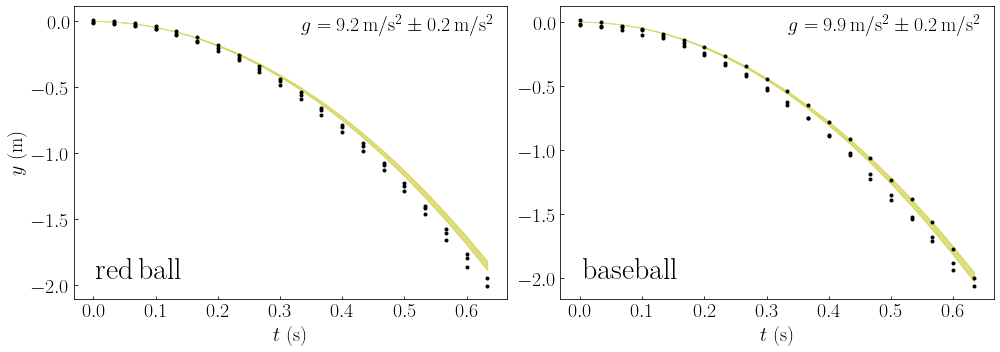

In [28]:
f = lambda g_,t: g_*t**2.0/2.0

nrows=1;ncols=2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

t_vals = frame_rate*np.arange(0,20)

red_upper_lower = get_upper_lower(f,t_vals,g_red,g_red_err)
base_upper_lower = get_upper_lower(f,t_vals,g_base,g_base_err)
ax[0].fill_between(t_vals.magnitude,red_upper_lower[0].magnitude,red_upper_lower[1].magnitude,color='y',alpha=0.5)
ax[1].fill_between(t_vals.magnitude,base_upper_lower[0].magnitude,base_upper_lower[1].magnitude,color='y',alpha=0.5)

for i in range(2):
    key = list(drop_data.keys())[i]
    pos = drop_data[key]['pos']
    for j in range(len(pos)):
        ax[i].plot(t_vals[:len(pos[j])].magnitude,pos[j].magnitude,'k.')
        
ax[0].text(0.97,0.9,r'$g = {:.1fLx} \pm {:.1fLx}$'.format(abs(g_red),g_red_err),
                      size=20,transform=ax[0].transAxes,va='bottom',ha='right')
ax[1].text(0.97,0.9,r'$g = {:.1fLx} \pm {:.1fLx}$'.format(abs(g_base),g_base_err),
                      size=20,transform=ax[1].transAxes,va='bottom',ha='right')

for i in range(2):
    if i == 0: ball = r'$\rm red\,ball$'
    elif i == 1: ball = r'$\rm baseball$'
    ax[i].text(0.05,0.05,ball,size=30,transform=ax[i].transAxes,va='bottom',ha='left')
    ax[i].set_xlabel(r'$t~({:Lx})$'.format(t_vals.units),size=20)
    ax[i].tick_params(axis='both',which='major',labelsize=20,direction='in')
ax[0].set_ylabel(r'$y~({:Lx})$'.format(pos[0].units),size=20)

plt.tight_layout()
plt.show()

In [29]:
def get_acc_prec(g_mean,g_err):
    g_acc = Q_(-9.80665,'m/s**2')
    rel_unc = abs(g_err/g_mean) * 100.0
    z = abs((g_mean - g_acc)/g_err)
    rel_diff = abs((g_mean - g_acc)/g_acc) * 100.0
    print('relative uncertainty: {:.2f}%'.format(rel_unc.magnitude))
    print(r'percent difference: {:.2f}%'.format(rel_diff.magnitude))
    print('z value: %.2f'%z)
    # return rel_unc,z,rel_diff

In [30]:
get_acc_prec(g_red,g_red_err)

relative uncertainty: 1.87%
percent difference: 5.90%
z value: 3.36


In [31]:
get_acc_prec(g_base,g_base_err)

relative uncertainty: 1.86%
percent difference: 1.10%
z value: 0.59


## Ball Drop with timing

In [32]:
h = Q_(2.0,'m')
dh = Q_(5.0,'cm')
dt = Q_(200.0,'ms')

In [33]:
### Initialize drop data
# drop_data = {}
# drop_data['red']  = {}
# drop_data['base'] = {}

# for _ in list(drop_data.keys()):
#     drop_data[_]['times'] = []
    
### Red Ball

red_times = Q_(np.array([0.51,0.53,0.50,0.46,0.65]),'s')
# red_times = np.sqrt(2*h/Q_(9.8,'m/s**2')) + Q_(np.random.normal(0,0.3,5),'s')
    
# drop_data['red']['times'].append(Q_(0,'m'))
# drop_data['red']['times'].append(Q_(0,'m'))
# drop_data['red']['times'].append(Q_(0,'m'))
# drop_data['red']['times'].append(Q_(0,'m'))
# drop_data['red']['times'].append(Q_(0,'m'))

### Baseball

base_times = Q_(np.array([0.65,0.61,0.73,0.58,0.63]),'s')
# base_times = np.sqrt(2*h/Q_(9.8,'m/s**2')) + Q_(np.random.normal(0,0.3,5),'s')


# drop_data['base']['times'].append(Q_(0,'m'))
# drop_data['base']['times'].append(Q_(0,'m'))
# drop_data['base']['times'].append(Q_(0,'m'))
# drop_data['base']['times'].append(Q_(0,'m'))
# drop_data['base']['times'].append(Q_(0,'m'))


### guiding equation
$g = 2h/t^2$  
$t = \sqrt{2h/g}$

In [34]:
def g_error(T,dT):
    error_h = 2 / T**2.0 * dh
    error_t = -4.0 * h / T**3.0 * dT
    return np.sqrt(error_h**2.0 + error_t**2.0)

def analyze(times):
    t = np.mean(times)
    t_err = dt/float(len(times))
    
    g_mean = 2 * h / t**2.0
    g_err = g_error(t,t_err)
    
    return g_mean,g_err.to(g_mean.units)

In [35]:
g_red  = analyze(red_times)
g_base = analyze(base_times)
print('red ball: g = {:.0f~P} +- {:.0f~P}'.format(g_red[0],g_red[1]))
print('baseball: g = {:.0f~P} +- {:.0f~P}'.format(g_base[0],g_base[1]))

red ball: g = 14 m/s² +- 2 m/s²
baseball: g = 10 m/s² +- 1 m/s²


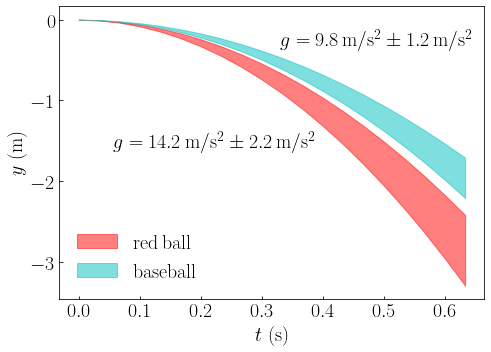

In [41]:
f = lambda g_,t: -g_*t**2.0/2.0

nrows=1;ncols=1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

t_vals = frame_rate*np.arange(0,20)

red_upper_lower = get_upper_lower(f,t_vals,g_red[0],g_red[1])
base_upper_lower = get_upper_lower(f,t_vals,g_base[0],g_base[1])
ax.fill_between(t_vals.magnitude,red_upper_lower[0].magnitude,red_upper_lower[1].magnitude,color='r',alpha=0.5,label=r'$\rm red\,ball$')
ax.fill_between(t_vals.magnitude,base_upper_lower[0].magnitude,base_upper_lower[1].magnitude,color='c',alpha=0.5,label=r'$\rm baseball$')

ax.legend(fontsize=20,loc='lower left',frameon=False)
ax.text(0.52,0.85,r'$g = {:.1f~Lx} \pm {:.1f~Lx}$'.format(g_base[0],g_base[1]),size=20,transform=ax.transAxes,va='bottom',ha='left')
ax.text(0.6,0.5,r'$g = {:.1f~Lx} \pm {:.1f~Lx}$'.format(g_red[0],g_red[1]),size=20,transform=ax.transAxes,va='bottom',ha='right')
# ax.text(0.05,0.05,ball,size=20,transform=ax.transAxes)#,va='bottom',ha='left')
ax.set_xlabel(r'$t~({:Lx})$'.format(t_vals.units),size=20)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.set_ylabel(r'$y~({:Lx})$'.format(pos[0].units),size=20)

plt.tight_layout()
plt.show()

In [37]:
def get_acc_prec(g_mean,g_err):
    g_acc = Q_(9.80665,'m/s**2')
    rel_unc = abs(g_err/g_mean) * 100.0
    z = abs((g_mean - g_acc)/g_err)
    rel_diff = abs((g_mean - g_acc)/g_acc) * 100.0
    print('relative uncertainty: {:.2f}%'.format(rel_unc.magnitude))
    print(r'percent difference: {:.2f}%'.format(rel_diff.magnitude))
    print('z value: %.2f'%z)

In [38]:
print('red ball')
get_acc_prec(g_red[0],g_red[1])
print()
print('base ball')
get_acc_prec(g_base[0],g_base[1])

red ball
relative uncertainty: 15.30%
percent difference: 45.21%
z value: 2.03

base ball
relative uncertainty: 12.75%
percent difference: 0.42%
z value: 0.03


In [ ]:
f = lambda g,t: -g/2.0*t**2.0

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(14,10))

max_frames = 0
for _ in drop_data.keys():
    if _ == 'red': linestyle='r.'
    if _ == 'base': linestyle='k.'
    for arr in drop_data[_]['pos']:
        if len(arr) > max_frames: max_frames = len(arr)
        ax.plot(frame_rate*np.arange(0,len(arr)),arr,linestyle)
t_vals = frame_rate*np.arange(0,max_frames)
max_vals = f(np.mean(g_fits)+np.std(g_fits),t_vals)
min_vals = f(np.mean(g_fits)-np.std(g_fits),t_vals)
ax.fill_between(t_vals,max_vals,min_vals,color='y',alpha=0.5)
ax.plot(t_vals,f(np.mean(g_fits),t_vals),'g--')
# g = lambda t: popt/2.0*t**2.0
# plt.plot(drop_data['red']['time'][0],f(drop_data['red']['time'][0]),'r-')
# plt.plot(drop_data['red']['time'][0],g(drop_data['red']['time'][0]),'c-')
plt.show()

In [ ]:
vel = derivative(drop_data['red']['pos'][0],drop_data['red']['time'][0])
acc = derivative(vel,drop_data['red']['time'][0])

In [ ]:
def func(t,g):
    return -g

for _ in drop_data.keys():
    for arr in drop_data[_]['pos']:
        v
        popt,pcov = curve_fit(func,np.arange(0,len(a))/len(a),a)
        print(popt)
        # print(popt[0] - 2*pcov[0][0])
        np.sqrt(np.diag(pcov))

In [ ]:
plt.plot(drop_data['red']['time'][0],vel,'k.')
plt.plot(drop_data['red']['time'][0],acc,'r.')
plt.axhline(y=popt)

In [ ]:
mean = popt[0]
err  = np.sqrt(pcov[0][0])
x = np.linspace(norm.ppf(0.01,mean,err),norm.ppf(0.99,mean,err), 100)
z = abs(mean + 9.8)/err
print(z,mean-z*err)
xp = np.linspace(mean-z*err,mean+z*err,100)
plt.plot(x,norm.pdf(x,mean,err),'k')
plt.plot(-9.8,norm.pdf(-9.8,mean,err),'yo')
plt.fill_between(xp,norm.pdf(xp,mean,err),color='red')

In [ ]:
x